In [101]:
# import files and libraries

import generative_breastCancer_model as gm
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from scipy.ndimage import convolve as conv
from scipy.stats import multivariate_normal as mvn

ct_interactions = np.genfromtxt("/Users/bp/data/cellular_automata_bio394/ct_interactions_knn8.csv",delimiter=",",skip_header=True)
total_freq = np.genfromtxt("/Users/bp/data/cellular_automata_bio394/total_freq.csv",delimiter=",")
distance_matrix = pd.read_csv("/Users/bp/data/cellular_automata_bio394/distance_matrix.csv")


In [9]:
distance_matrix

,metacluster,Estimate,Std. Error
0,1,13.168731,0.082493
1,2,15.593909,0.105401
2,3,16.655721,0.084952
3,4,18.067907,0.088841
4,5,14.815928,0.115954
5,6,16.289067,0.252312
6,7,16.775976,0.090157
7,8,18.636206,0.086760
8,9,23.439914,0.087471
9,10,17.612847,0.084040


In [2]:
# set dimension

dimx, dimy = 55,55
cellsize=1000/dimx

In [3]:
e = gm.Board(dimx,dimy,transition_matrix=ct_interactions,total_freq = total_freq,cellsize=cellsize)

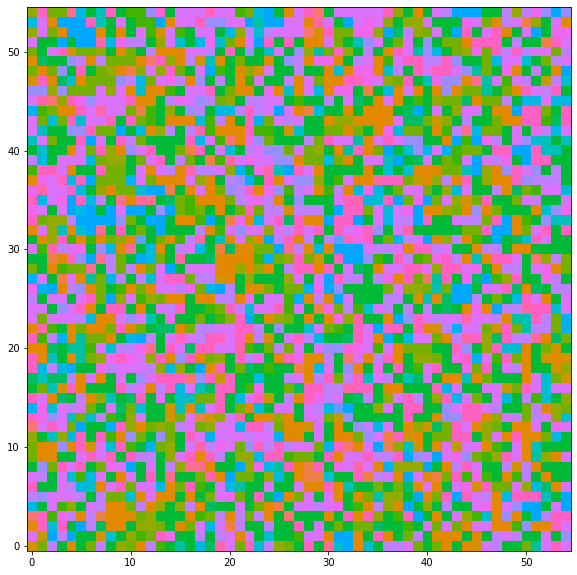

In [4]:
gm.generate(e,plot=True,generate_func=gm.generate_conv)

In [5]:
def open_neighbors(cells,x,y):    
    #compute possible moves at position x,y in cells.state    
    moves = np.array([[[-1,-1],[-1,0],[-1,1]],
                 [[0,-1],[0,0],[0,1]],
                 [[1,-1],[1,0],[1,1]]])

    left_bound = x-1
    left = 0
    right_bound = x+2
    right = 3
    upper_bound = y-1
    upper = 0
    lower_bound = y+2
    lower = 3
    #check if at right or left boundary
    if x == cells.dimx-1:
        right_bound = x+1
        right -=1
    elif x == 0:
        left_bound = 0
        left +=1
    #check if at upper or lower boundary
    if y == cells.dimy-1:
        lower_bound = y+1
        lower -=1
    elif y == 0:
        upper_bound = 0
        upper +=1
    
    neig = cells.processed[upper_bound:lower_bound,left_bound:right_bound]
    moves = moves[upper:lower,left:right]
    open_pos = neig == 0
    possible_moves = moves[open_pos]
    
    #no possible moves
    if not possible_moves.any():
        return []
    else:
        return possible_moves

In [6]:
def best_start(cells):

    kernel = [[1,1,1],
              [1,0,1],
              [1,1,1]]
    defined_positions = np.array(cells.processed!=0,dtype=int)
    neig_count = conv(defined_positions,kernel,mode="constant",cval=0)
    #only consider unused spaces
    neig_count[cells.processed!=0] = -1
    #max number of neigbors
    maxi = np.max(neig_count)
    #if -1 then no open positions left
    if maxi == -1:
        return -1,-1
    #consider only positions with the most amount of information given
    open_pos = np.argwhere(neig_count==maxi)
    #choose one of the neighbors randomly and continue walk
    new_y,new_x = open_pos[np.random.randint(0,len(open_pos))]
   
    return new_y,new_x

In [102]:
def get_sd(metacluster):
    return distance_matrix[distance_matrix.metacluster==1]["Std. Error"].values

In [103]:
def get_mu(metacluster):
        return distance_matrix[distance_matrix.metacluster==1]["Estimate"].values

In [41]:
def get_pos(pred_pos,radius,angle):
    """ distance distribution is only dependent on i and not j """
    x_pos = radius * math.cos(angle) + pred_pos[0]
    y_pos = radius * math.sin(angle) + pred_pos[1]
    return x_pos,y_pos
    

In [104]:
# todo: add estimation of mu and sigma for distance matrix
# todo: implement networkX

def spread_spatial(cells):
    # choose random start
    y_start,x_start = np.random.choice(cells.states.shape[0]),np.random.choice(cells.states.shape[1])
    metacluster = cells.states[y_start,x_start]
    
    # create array to keep track which cells where already processed (=1)
    cells.processed = np.zeros(cells.states.shape)
    
    # initiate pandas dataframe
    dic = {"x": [x_start], "y":[y_start], "metacluster":[metacluster]}
    graph_df = pd.DataFrame(dic)
    cells.processed[y_start,x_start] = 1
    
    x,y = x_start,y_start
    pred_pos = x_start,y_start
    while len(np.argwhere(cells.processed == 0)) > 0:
        possible_moves = open_neighbors(cells,x,y)
        #if no moves possible from position x,y then search for new position
        if len(possible_moves) == 0:
            new_y,new_x = best_start(cells)
    
        #if no moves possible with best_start we are finished
            if new_y == -1:
                break
        else:    
            #choose one of the possible moves
            delta_y, delta_x = possible_moves[np.random.randint(0,len(possible_moves))]
            
            #compute new position
            new_x, new_y = x+delta_x, y+delta_y
        
        # state of cell that will be processed
        state = cells.states[new_x,new_y]
        #compute all neighbors that contain information
        
        neig = gm.neighbors(cells, new_x, new_y)
        
        # take all spatial neighbors into account
        ## todo: create distribution and sample from it
        #pdf = np.zeros()
        #for s in neig:
        #    if s == 0:
        #        continue
        #    else:
        #        pdf += get_pde()
        #        count_neig += 1
        
        ## sampling of new_x and new_y
        #new_x,new_y = sample(pdf)
        
        
        
        # take only one neighbor into account
        # randomly choose a neighbor
        one_neig = np.random.choice(neig)
        # compute sd and mean depending on one neighbor
        mu = get_mu(one_neig)
        sd = get_sd(one_neig)
        # sample from that distribution and choose random angle
        radius = np.random.normal(mu,sd)
        angle = 2 * math.pi * np.random.random()
        x_pos, y_pos = get_pos(pred_pos,radius,angle)

        
        
        # insert processed cell
        graph_df.loc[len(graph_df.index)] = [float(x_pos),float(y_pos),int(state)]
        # in sample: update position
        pred_pos = x_pos,y_pos

        
        # in grid: update position
        cells.processed[new_y,new_x] = 1
        x,y = new_x,new_y
    print(len(np.argwhere(cells.processed == 0)))
    return graph_df
    

In [88]:
final_df = spread_spatial(e)

0


In [89]:
final_df

,x,y,metacluster
0,28.000000,40.000000,8.0
1,24.710056,52.826665,23.0
2,32.644432,63.244911,21.0
3,36.115660,75.856805,3.0
4,37.833496,88.934192,7.0
...,...,...,...
3020,77.376680,-357.235186,18.0
3021,89.591762,-361.987665,22.0
3022,86.665572,-349.242601,25.0
3023,73.492696,-350.833149,25.0


In [90]:
meta_clusters = {1:"B cell",2:"T & B cells",3:"T cell",4:"Macrophage",5:"T cell",
                 6:"Macrophage",7:"Endothelial",8:"Vimentin hi",9:"Small circular",10:"Small elongated",
                 11:"Fibronectin hi",12:"Large elongated",13:"SMA hi Vimentin hi",14:"Hypoxic",15:"Apoptotic",
                 16:"Proliferative",17:"p53+ EGFR+",18:"Basal CK",19:"CK7+ CK hi Ecadh hi",20:"CK7+",
                 21:"Epithelial low",22:"CK lo HR lo",23:"CK+ HR hi",24:"CK+ HR+",25:"CK+ HR lo",
                 26:"CK lo HR hi p53+",27:"Myoepithelial"}
colors_list = ["#F8766D" ,"#EE8045" ,"#E28900" ,"#D39200" ,"#C19B00" ,"#ACA300" ,"#93AA00" ,"#73B000" ,"#41B500",
          "#00BA38" ,"#00BD63" ,"#00C083" ,"#00C19F" ,"#00C0B9" ,"#00BECF" ,"#00B9E3" ,"#00B2F4" ,"#00A8FF",
          "#619CFF" ,"#998EFF" ,"#BF80FF" ,"#DB72FB" ,"#EE67EC" ,"#FA62DA" ,"#FF61C3" ,"#FF66AA" ,"#FF6C91"]
color_dic = {key+1:val for key,val in enumerate(colors_list)}

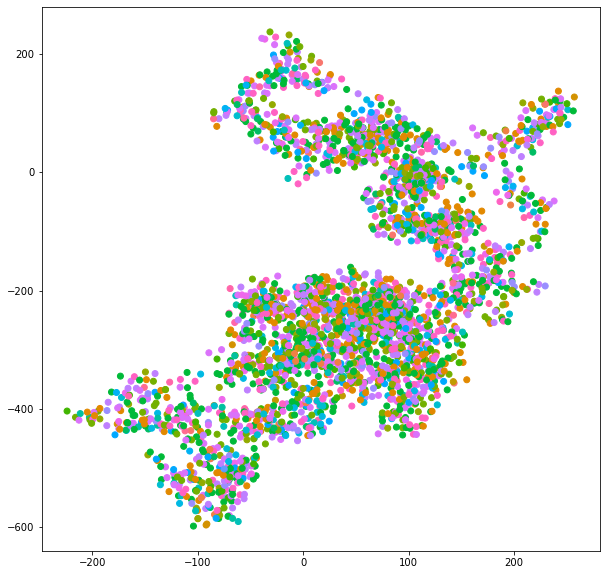

In [96]:
# plot
cmap = colors.ListedColormap(colors_list)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=final_df.x,y=final_df.y,c=final_df.metacluster,cmap=cmap)

In [105]:
def get_pdf(metacluster):
    mu = get_mu(metacluster)
    sd = get_sd(metacluster)
    
    mu = np.array([mu,mu])
    cov = np.array([[sd,0],[0,sd]])
    
    # create x and y meshgrid
    N = 600
    x = np.linspace(-30,30,N)
    y = np.linspace(-30,30,N)
    X, Y = np.meshgrid(x,y)
    
    # pack x and Y into a single 3d array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    f = mvn(mu,cov)
    Z = f.pdf(pos)
    
    # normalize probability array
    Z = Z/np.sum(Z)
    
    return Z
    

In [106]:
def sample(Z):
    # with numpy only 1d is possible, so we flatten the probablity array and the sample array (index of positions)
    flat_density = Z.flatten()

    # sample x and y with given distribution
    sample_index = np.random.choice(flat_density.size,p=flat_density)

    # re-adjust to original array
    adjusted_index = np.unravel_index(sample_index,Z.shape)

    # convert index into position on our grid
    pos = X[0,adjusted_index[0]],Y[adjusted_index[1],0]
    return pos


In [98]:
def spread_spatial2(cells):
    # choose random start
    y_start,x_start = np.random.choice(cells.states.shape[0]),np.random.choice(cells.states.shape[1])
    metacluster = cells.states[y_start,x_start]
    
    # create array to keep track which cells where already processed (=1)
    cells.processed = np.zeros(cells.states.shape)
    
    # initiate pandas dataframe
    dic = {"x": [x_start], "y":[y_start], "metacluster":[metacluster]}
    graph_df = pd.DataFrame(dic)
    cells.processed[y_start,x_start] = 1
    
    x,y = x_start,y_start
    pred_pos = x_start,y_start
    while len(np.argwhere(cells.processed == 0)) > 0:
        possible_moves = open_neighbors(cells,x,y)
        #if no moves possible from position x,y then search for new position
        if len(possible_moves) == 0:
            new_y,new_x = best_start(cells)
    
        #if no moves possible with best_start we are finished
            if new_y == -1:
                break
        else:    
            #choose one of the possible moves
            delta_y, delta_x = possible_moves[np.random.randint(0,len(possible_moves))]
            
            #compute new position
            new_x, new_y = x+delta_x, y+delta_y
        
        # state of cell that will be processed
        state = cells.states[new_x,new_y]
        #compute all neighbors that contain information
        
        neig = gm.neighbors(cells, new_x, new_y)
        
        # take all spatial neighbors into account
        # todo: create distribution and sample from it
        pdf = get_pdf()
        delta_x,delta_y = sample(pdf)

        
        # insert processed cell
        graph_df.loc[len(graph_df.index)] = [float(x_pos),float(y_pos),int(state)]
        # in sample: update position
        pred_pos = x_pos,y_pos

        
        # in grid: update position
        cells.processed[new_y,new_x] = 1
        x,y = new_x,new_y
    print(len(np.argwhere(cells.processed == 0)))
    return graph_df

In [99]:
second_df = spread_spatial2(e)

0


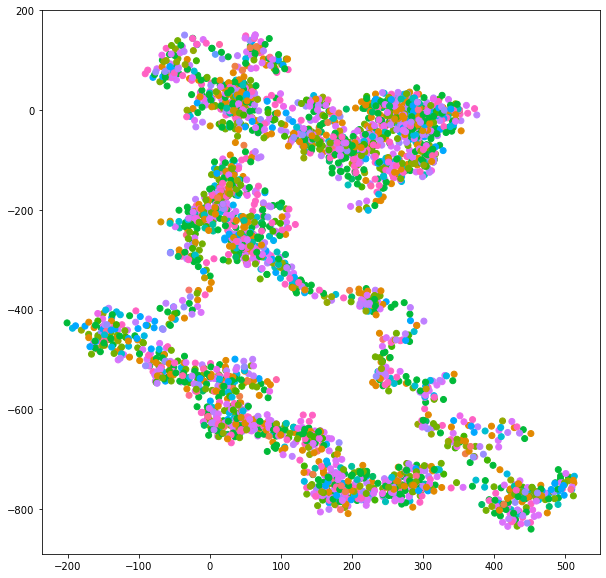

In [100]:
# plot

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=second_df.x,y=second_df.y,c=second_df.metacluster,cmap=cmap)